In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import cv2
from skimage import data, transform
from skimage.util import montage
from skimage.transform import rotate
from PIL import Image, ImageOps
import imageio

import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
import keras.backend as K
from keras.callbacks import CSVLogger

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Multiply, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import MeanIoU


In [2]:
def check_image_size(patient_id, dataset_path):
    # Load the image using nibabel
    image_flair = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_flair.nii')).get_fdata()
    image_t1 = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t1.nii')).get_fdata()
    image_t1ce = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t1ce.nii')).get_fdata()
    image_t2 = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t2.nii')).get_fdata()
    mask = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_seg.nii')).get_fdata()

    # Get sizes of each image
    size_flair = image_flair.shape
    size_t1 = image_t1.shape
    size_t1ce = image_t1ce.shape
    size_t2 = image_t2.shape
    size_mask = mask.shape

    # Print sizes
    print(f"Image flair size: {size_flair}")
    print(f"Image t1 size: {size_t1}")
    print(f"Image t1ce size: {size_t1ce}")
    print(f"Image t2 size: {size_t2}")
    print(f"Mask size: {size_mask}")

# Example usage
TRAIN_DATASET_PATH = r'archive\BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id = 5  # Example patient ID

check_image_size(patient_id, TRAIN_DATASET_PATH)


Image flair size: (240, 240, 155)
Image t1 size: (240, 240, 155)
Image t1ce size: (240, 240, 155)
Image t2 size: (240, 240, 155)
Mask size: (240, 240, 155)


In [3]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

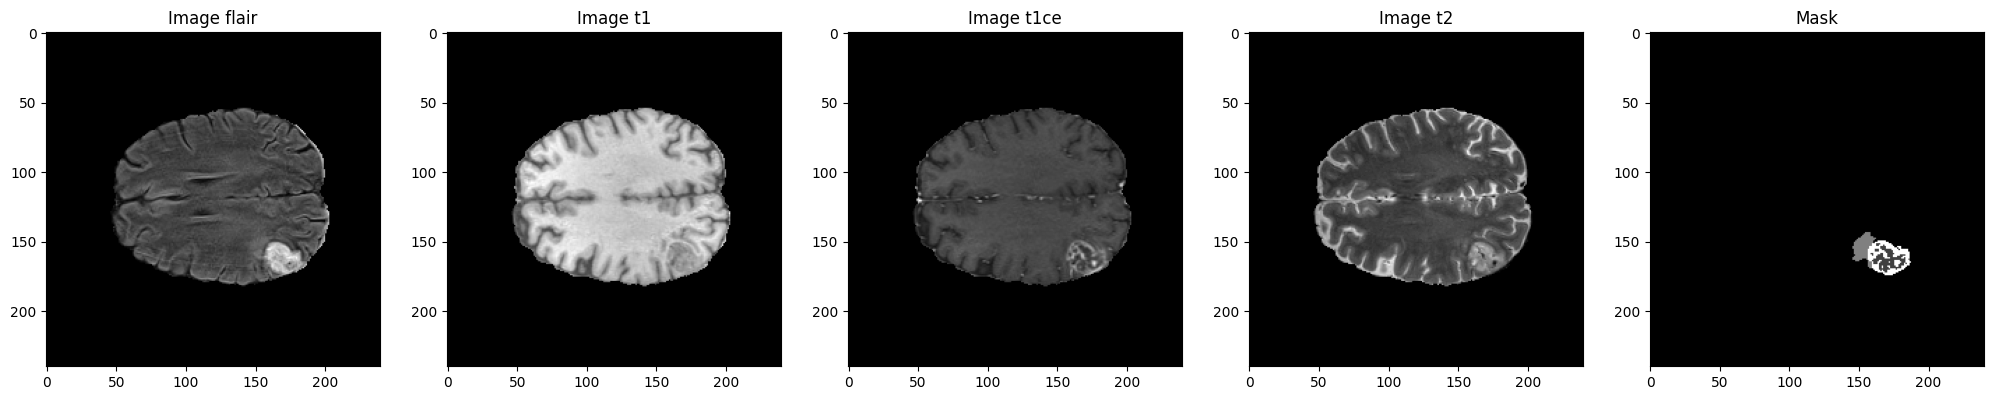

In [4]:
def load_data(patient_id, dataset_path):
    image_flair = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_flair.nii')).get_fdata()
    image_t1 = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t1.nii')).get_fdata()
    image_t1ce = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t1ce.nii')).get_fdata()
    image_t2 = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t2.nii')).get_fdata()
    mask = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_seg.nii')).get_fdata()
    
    return image_flair, image_t1, image_t1ce, image_t2, mask

def plot_images(images, titles, slice_w):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image[:, :, image.shape[0] // 2 - slice_w], cmap='gray')
        axes[i].set_title(title)

# Example usage
TRAIN_DATASET_PATH = r'archive\BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
patient_id = 5  # Example patient ID
slice_w = 25

images = load_data(patient_id, TRAIN_DATASET_PATH)
image_titles = ['Image flair', 'Image t1', 'Image t1ce', 'Image t2', 'Mask']

plot_images(images, image_titles, slice_w)
plt.show()


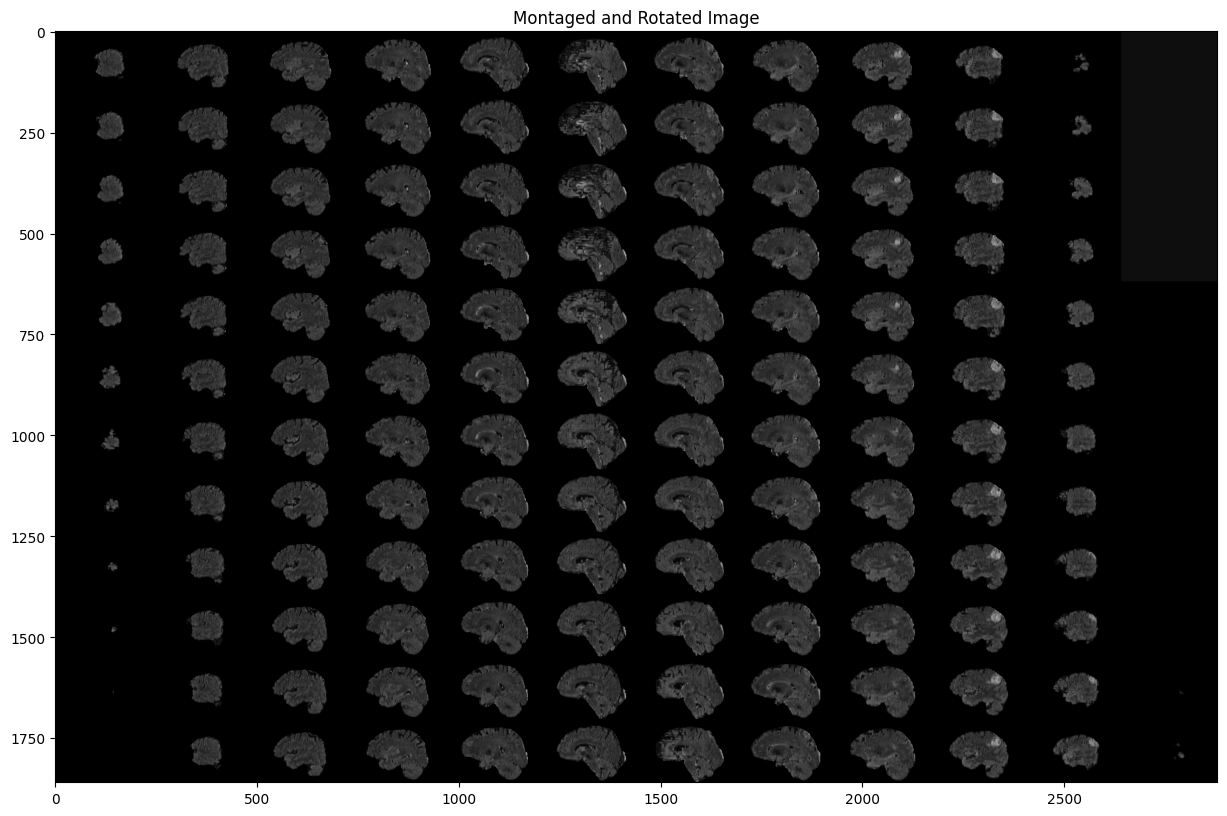

In [5]:
def plot_montage(image, slice_skip):
    montaged_image = montage(image[slice_skip:-slice_skip, :, :])
    rotated_image = rotate(montaged_image, 90, resize=True)
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(rotated_image, cmap='gray')
    ax.set_title('Montaged and Rotated Image')

slice_skip = 50
plot_montage(images[0], slice_skip=slice_skip)  # Plotting montaged and rotated t1 image
plt.show()

In [6]:
def load_data(patient_id, dataset_path):
    image_flair = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_flair.nii')).get_fdata()
    image_t1 = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t1.nii')).get_fdata()
    image_t1ce = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t1ce.nii')).get_fdata()
    image_t2 = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_t2.nii')).get_fdata()
    mask = nib.load(os.path.join(dataset_path, f'BraTS20_Training_{patient_id:03d}', f'BraTS20_Training_{patient_id:03d}_seg.nii')).get_fdata()
    
    return image_flair, image_t1, image_t1ce, image_t2, mask

def create_and_save_gif(patient_id, dataset_path):
    
    image_flair, _, _, _, mask = load_data(patient_id, dataset_path)

    label = f'BraTS20_Training_{patient_id:03d}'  
    filename = f'{label}_3d_2d.gif'

    frames = []

    for i in range(image_flair.shape[2]):
        image = np.rot90(image_flair[:, :, i])
        mask_slice = np.clip(np.rot90(mask[:, :, i]), 0, 255).astype(np.uint8) * 255 
        combined_image = np.stack([image, image, image], axis=-1) 
        combined_image[..., 0] += mask_slice  
        frames.append(combined_image)

    imageio.mimsave(filename, frames, fps=15)

    print(f'GIF saved successfully as: {filename}')

# Example usage:
patient_id = 1  
dataset_path = 'archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData' 
create_and_save_gif(patient_id, dataset_path)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 276.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 274.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 364.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 346.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from fl

GIF saved successfully as: BraTS20_Training_001_3d_2d.gif



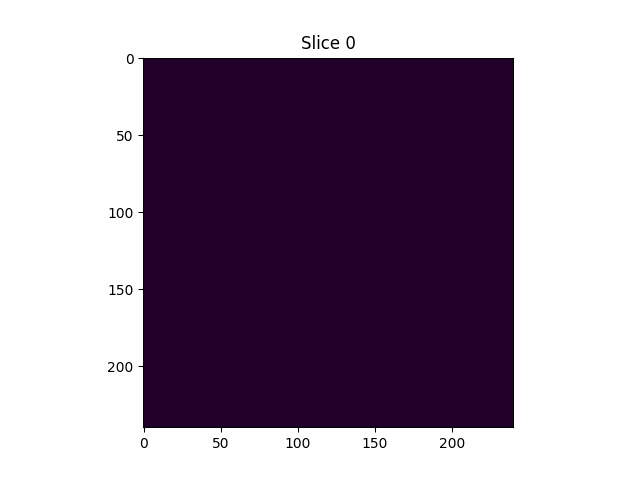

In [7]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display, HTML
import base64

def create_and_save_gif(sample_img_filename, sample_mask_filename, output_filename):
    sample_img = nib.load(sample_img_filename)
    sample_img_data = np.asanyarray(sample_img.dataobj)
    
    sample_mask = nib.load(sample_mask_filename)
    sample_mask_data = np.asanyarray(sample_mask.dataobj)
    
    num_slices = sample_img_data.shape[2]
    
    fig, ax = plt.subplots()
    ax.axis('off')
    
    def update(frame):
        ax.clear()
        image = sample_img_data[:, :, frame]
        mask = sample_mask_data[:, :, frame]
        
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, cmap='viridis', alpha=0.5)
        ax.set_title(f"Slice {frame}")
        
    # Create animation
    animation = FuncAnimation(fig, update, frames=num_slices, blit=False)
    animation.save(output_filename, writer='pillow', fps=10) 
    
    plt.close(fig) 

# Example usage
sample_img_filename = 'archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sample_mask_filename = 'archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'
output_filename = 'sample_output.gif'

create_and_save_gif(sample_img_filename, sample_mask_filename, output_filename)


def show_gif(filename):
    with open(filename, 'rb') as file:
        gif_binary = file.read()
        gif_base64 = base64.b64encode(gif_binary).decode()
        html_str = f'<img src="data:image/gif;base64,{gif_base64}">'
        display(HTML(html_str))

show_gif(output_filename)


In [8]:
# shutil.copy2(TRAIN_DATASET_PATH + '\BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
# gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

In [9]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [10]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories = [dir_path for dir_path in train_and_val_directories if not dir_path.endswith('BraTS20_Training_355')]

def pathListIntoIds(dirList):
    return [dir_path.split(os.path.sep)[-1] for dir_path in dirList]

train_and_test_ids = pathListIntoIds(train_and_val_directories)


train_ids, test_ids = train_test_split(train_and_test_ids, test_size=0.15, random_state=42)

print(f"Number of training IDs: {len(train_ids)}")
print(f"Number of test IDs: {len(test_ids)}")


Number of training IDs: 312
Number of test IDs: 56


In [12]:
IMG_SIZE = 240

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, Y = self.__data_generation(Batch_ids)
        return X, Y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            flair_path = os.path.join(case_path, f'{i}_flair.nii')
            ce_path = os.path.join(case_path, f'{i}_t1ce.nii')
            t1_path = os.path.join(case_path, f'{i}_t1.nii')
            t2_path = os.path.join(case_path, f'{i}_t2.nii')
            seg_path = os.path.join(case_path, f'{i}_seg.nii')

            flair = nib.load(flair_path).get_fdata().astype(np.float32) 
            ce = nib.load(ce_path).get_fdata().astype(np.float32)
            t1 = nib.load(t1_path).get_fdata().astype(np.float32)
            t2 = nib.load(t2_path).get_fdata().astype(np.float32)
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                # Gaussian smoothing and adaptive Gaussian thresholding
                flair_smooth = cv2.GaussianBlur(flair[:, :, j + VOLUME_START_AT], (3, 3), 0).astype(np.uint8)
                ce_smooth = cv2.GaussianBlur(ce[:, :, j + VOLUME_START_AT], (3, 3), 0).astype(np.uint8)
                t1_smooth = cv2.GaussianBlur(t1[:, :, j + VOLUME_START_AT], (3, 3), 0).astype(np.uint8)
                t2_smooth = cv2.GaussianBlur(t2[:, :, j + VOLUME_START_AT], (3, 3), 0).astype(np.uint8)

                # Adaptive Gaussian thresholding
                _, flair_thresh = cv2.threshold(flair_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                _, ce_thresh = cv2.threshold(ce_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                _, t1_thresh = cv2.threshold(t1_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                _, t2_thresh = cv2.threshold(t2_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

               # Resize to desired dimensions
                flair_resized = cv2.resize(flair_thresh, (IMG_SIZE, IMG_SIZE))
                ce_resized = cv2.resize(ce_thresh, (IMG_SIZE, IMG_SIZE))
                t1_resized = cv2.resize(t1_thresh, (IMG_SIZE, IMG_SIZE))
                t2_resized = cv2.resize(t2_thresh, (IMG_SIZE, IMG_SIZE))

                # Store in X
                X[j + VOLUME_SLICES * c, :, :, 0] = flair_resized
                X[j + VOLUME_SLICES * c, :, :, 1] = ce_resized
                X[j + VOLUME_SLICES * c, :, :, 2] = t1_resized
                X[j + VOLUME_SLICES * c, :, :, 3] = t2_resized

                # Resize segmentation and convert to one-hot encoding
                resized_seg = cv2.resize(seg[:, :, j + VOLUME_START_AT].astype(np.uint8), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                resized_seg[resized_seg == 4] = 3
                one_hot_seg = tf.one_hot(resized_seg, 4)
                Y[j + VOLUME_SLICES * c, :, :, :] = one_hot_seg

        return X / 255.0, Y


# Usage example:
train_generator = DataGenerator(train_ids)
test_generator = DataGenerator(test_ids)


In [13]:
batch_X, batch_Y = test_generator[0]
print(f"Shape of X (input images): {batch_X.shape}, Shape of Y (one-hot encoded segmentation): {batch_Y.shape}")

Shape of X (input images): (100, 240, 240, 4), Shape of Y (one-hot encoded segmentation): (100, 240, 240, 4)


C:\Users\Amit\AppData\Local\Temp\ipykernel_14992\125484237.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, batch_X.shape[-1] + 1, channel_idx + 1)


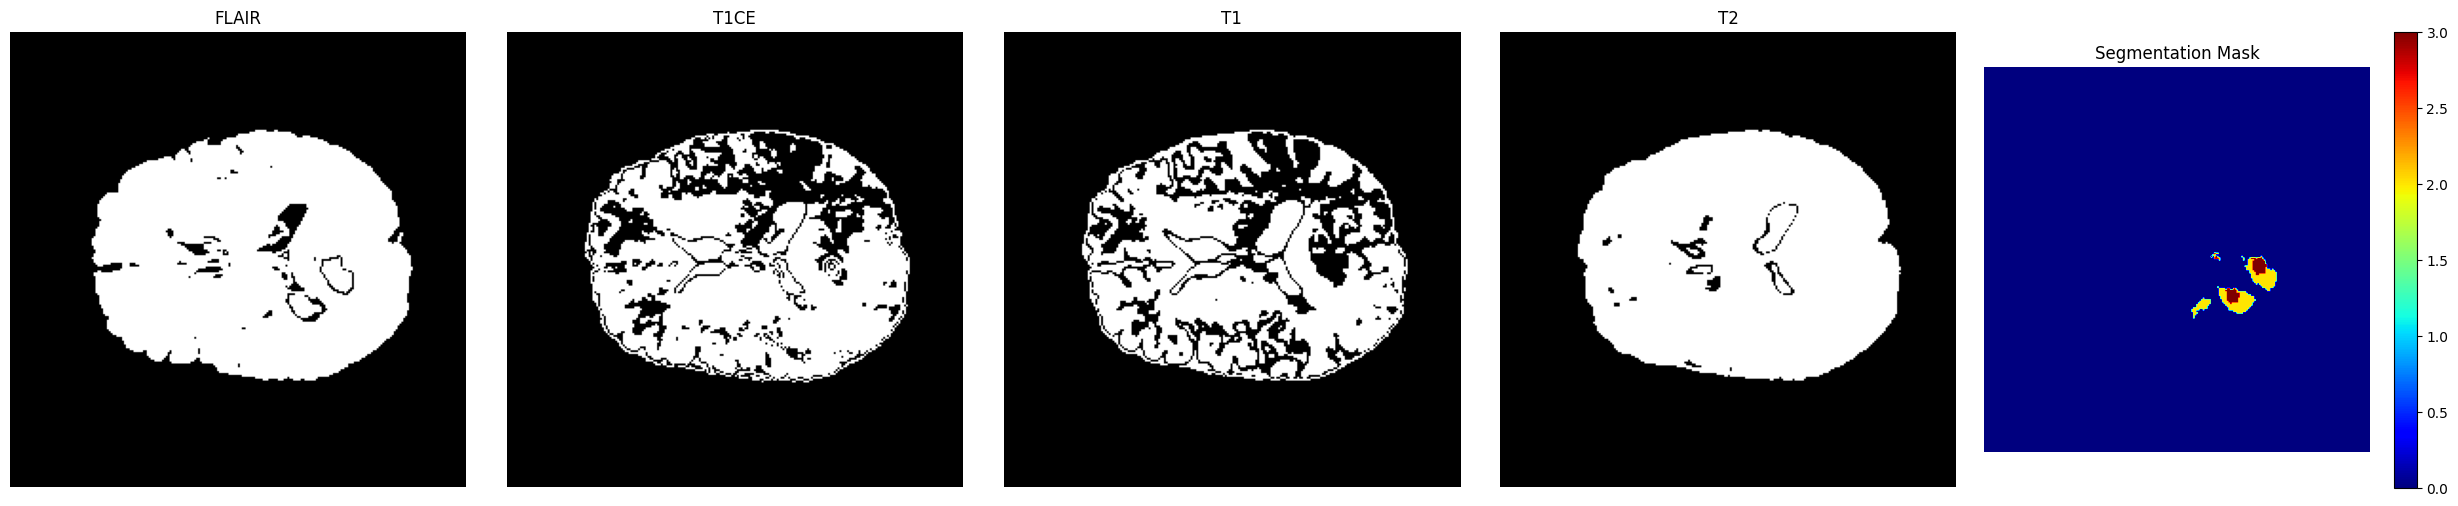

In [14]:
image_titles = ['FLAIR', 'T1CE', 'T1', 'T2', 'Segmentation Mask']

plt.figure(figsize=(25, 5))
plt.axis('off')

slice_idx = 50 
for channel_idx in range(batch_X.shape[-1]):
    plt.subplot(1, batch_X.shape[-1] + 1, channel_idx + 1)
    plt.imshow(batch_X[slice_idx, :, :, channel_idx], cmap='gray')
    plt.title(image_titles[channel_idx])
    plt.axis('off')

# Plot the segmentation mask
seg_mask = tf.argmax(batch_Y[slice_idx, :, :, :], axis=-1)
plt.subplot(1, batch_X.shape[-1] + 1, batch_X.shape[-1] + 1)
plt.imshow(seg_mask, cmap='jet', vmin=0, vmax=3)  
plt.title(image_titles[-1])
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


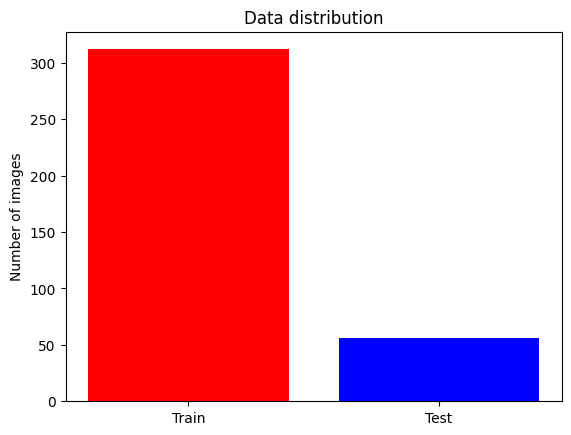

In [15]:
def showDataLayout(train_ids, test_ids):
    train_count = len(train_ids)
    test_count = len(test_ids)

    categories = ["Train",  "Test"]
    counts = [train_count, test_count]
    colors = ['red', 'blue']
    
    plt.bar(categories, counts, align='center', color=colors)
    plt.ylabel('Number of images')
    plt.title('Data distribution')
    
    plt.show()

showDataLayout(train_ids, test_ids)


In [16]:
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau

csv_logger = CSVLogger('training.log', separator=',', append=False)

callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
]


In [94]:
def build_unet(input_shape, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom/central layer
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Expansive path
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv9)

    # Output layer
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)  

    return Model(inputs=inputs, outputs=conv10)

input_shape = (240, 240, 4)  

model1 = build_unet(input_shape, num_classes=4)  

model1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

model1.summary()



Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_378 (Conv2D)         (None, 240, 240, 32)         1184      ['input_15[0][0]']            
                                                                                                  
 conv2d_379 (Conv2D)         (None, 240, 240, 32)         9248      ['conv2d_378[0][0]']          
                                                                                                  
 max_pooling2d_54 (MaxPooli  (None, 120, 120, 32)         0         ['conv2d_379[0][0]']          
 ng2D)                                                                                     

In [95]:
def build_ca_cnn(input_shape, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom/central layer
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv4)
    drop4 = Dropout(dropout)(conv4)

    # Expansive path
    up5 = Conv2D(128, (2, 2), activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(drop4))
    merge5 = Concatenate(axis=3)([conv3, up5])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv5)

    up6 = Conv2D(64, (2, 2), activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = Concatenate(axis=3)([conv2, up6])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv6)

    up7 = Conv2D(32, (2, 2), activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv1, up7])
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)

    # Additional convolutional layers for enhanced feature extraction (anisotropic)
    conv8 = Conv2D(64, (3, 1), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)
    conv9 = Conv2D(64, (1, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv8)

    # Output layer
    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

input_shape = (240, 240, 4)  

model2 = build_ca_cnn(input_shape, num_classes=4) 

model2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

model2.summary()


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_401 (Conv2D)         (None, 240, 240, 32)         1184      ['input_16[0][0]']            
                                                                                                  
 conv2d_402 (Conv2D)         (None, 240, 240, 32)         9248      ['conv2d_401[0][0]']          
                                                                                                  
 max_pooling2d_58 (MaxPooli  (None, 120, 120, 32)         0         ['conv2d_402[0][0]']          
 ng2D)                                                                                     

In [96]:
def build_vnet(input_shape, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom/central layer
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Expansive path
    up6 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=kernel_initializer)(drop5)
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv6)
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)

    up8 = Conv2DTranspose(32, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge8)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv8)

    up9 = Conv2DTranspose(16, 2, strides=(2, 2), activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv8)
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge9)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv9)

    # Output layer
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)  

    return Model(inputs=inputs, outputs=conv10)

input_shape = (240, 240, 4)  

model3 = build_vnet(input_shape, num_classes=4)  

model3.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

model3.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_421 (Conv2D)         (None, 240, 240, 16)         592       ['input_17[0][0]']            
                                                                                                  
 conv2d_422 (Conv2D)         (None, 240, 240, 16)         2320      ['conv2d_421[0][0]']          
                                                                                                  
 max_pooling2d_61 (MaxPooli  (None, 120, 120, 16)         0         ['conv2d_422[0][0]']          
 ng2D)                                                                                     

In [97]:
def build_attention_unet(input_shape, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom/central layer
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Expansive path with attention gates
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(drop5))
    up6 = AttentionGate(conv4, up6, 256)  # Attention gate between conv4 and up6
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = AttentionGate(conv3, up7, 128)  # Attention gate between conv3 and up7
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv7))
    up8 = AttentionGate(conv2, up8, 64)  # Attention gate between conv2 and up8
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv8))
    up9 = AttentionGate(conv1, up9, 32)  # Attention gate between conv1 and up9
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv9)

    # Output layer
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)  # Output with softmax activation for multi-class

    return Model(inputs=inputs, outputs=conv10)

def AttentionGate(g, x, out_channels):
    g_conv = Conv2D(out_channels, 1, activation='relu', padding='same')(g)
    x_conv = Conv2D(out_channels, 1, activation='relu', padding='same')(x)

    psi = tf.keras.activations.sigmoid(g_conv + x_conv)
    out = Multiply()([x, psi])
    return out

input_shape = (240, 240, 4)   

model4 = build_attention_unet(input_shape, num_classes=4)  

model4.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

model4.summary()


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_440 (Conv2D)         (None, 240, 240, 32)         1184      ['input_18[0][0]']            
                                                                                                  
 conv2d_441 (Conv2D)         (None, 240, 240, 32)         9248      ['conv2d_440[0][0]']          
                                                                                                  
 max_pooling2d_65 (MaxPooli  (None, 120, 120, 32)         0         ['conv2d_441[0][0]']          
 ng2D)                                                                                     

In [98]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    possible_negatives = tf.reduce_sum(1 - y_true)
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def build_nnunet(input_shape, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom/central layer
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Expansive path
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv9)

    # Output layer
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)  # Output with softmax activation for multi-class

    return Model(inputs=inputs, outputs=conv10)

input_shape = (240, 240, 4)  

model5 = build_nnunet(input_shape, num_classes=4) 

model5.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

model5.summary()


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_471 (Conv2D)         (None, 240, 240, 32)         1184      ['input_19[0][0]']            
                                                                                                  
 conv2d_472 (Conv2D)         (None, 240, 240, 32)         9248      ['conv2d_471[0][0]']          
                                                                                                  
 max_pooling2d_69 (MaxPooli  (None, 120, 120, 32)         0         ['conv2d_472[0][0]']          
 ng2D)                                                                                     

In [99]:
def residual_block(x, filters, kernel_size=3, dropout=0.2):
    # Save the input tensor for the residual connection
    input_tensor = x

    # First convolutional layer
    conv1 = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)

    # Second convolutional layer
    conv2 = Conv2D(filters, kernel_size, activation='relu', padding='same')(conv1)

    # Apply dropout if specified
    if dropout > 0:
        conv2 = Dropout(dropout)(conv2)

    # Check if the number of channels matches
    if input_tensor.shape[-1] != conv2.shape[-1]:
        # Adjust the number of channels using 1x1 convolution if needed
        input_tensor = Conv2D(filters, (1, 1), padding='same')(input_tensor)

    # Add the input tensor (with appropriate adjustment) to the output of the residual block
    residual = Add()([input_tensor, conv2])

    return residual

def build_unetr(input_shape, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # Contracting path with residual blocks
    conv1 = residual_block(inputs, 32)
    conv1 = residual_block(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 64)
    conv2 = residual_block(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 128)
    conv3 = residual_block(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 256)
    conv4 = residual_block(conv4, 256)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom/central layer
    conv5 = residual_block(pool4, 512)
    conv5 = residual_block(conv5, 512)
    drop5 = Dropout(dropout)(conv5)

    # Expansive path
    up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = residual_block(merge6, 256)
    conv6 = residual_block(conv6, 256)

    up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = residual_block(merge7, 128)
    conv7 = residual_block(conv7, 128)

    up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = residual_block(merge8, 64)
    conv8 = residual_block(conv8, 64)

    up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = residual_block(merge9, 32)
    conv9 = residual_block(conv9, 32)

    # Output layer
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)  

    return Model(inputs=inputs, outputs=conv10)

input_shape = (240, 240, 4)  

model6 = build_unetr(input_shape, num_classes=4) 

optimizer = Adam(learning_rate=0.001)
model6.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

model6.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_494 (Conv2D)         (None, 240, 240, 32)         1184      ['input_20[0][0]']            
                                                                                                  
 conv2d_495 (Conv2D)         (None, 240, 240, 32)         9248      ['conv2d_494[0][0]']          
                                                                                                  
 conv2d_496 (Conv2D)         (None, 240, 240, 32)         160       ['input_20[0][0]']            
                                                                                           

In [100]:
def build_nnformer(input_shape, num_classes=4, kernel_initializer='he_normal', dropout=0.2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom/central layer
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv5)

    # Expansive path
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(conv9)

    # Output layer
    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9) 

    return Model(inputs=inputs, outputs=conv10)

input_shape = (240, 240, 4)

model7 = build_nnformer(input_shape, num_classes=4)  

model7.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

model7.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_544 (Conv2D)         (None, 240, 240, 32)         1184      ['input_21[0][0]']            
                                                                                                  
 conv2d_545 (Conv2D)         (None, 240, 240, 32)         9248      ['conv2d_544[0][0]']          
                                                                                                  
 max_pooling2d_77 (MaxPooli  (None, 120, 120, 32)         0         ['conv2d_545[0][0]']          
 ng2D)                                                                                     

In [103]:
training_generator = DataGenerator(train_ids)
test_generator = DataGenerator(test_ids)

In [104]:
history= model1.fit(training_generator, epochs=1,steps_per_epoch=len(train_ids),callbacks= callbacks, validation_data=test_generator)

model1.save('unet_model.h5')

312/312 [==============================] - 5213s 17s/step - loss: 0.1676 - accuracy: 0.9823 - mean_io_u_14: 0.7608 - dice_coef: 0.2632 - precision: 0.9826 - sensitivity: 0.9739 - specificity: 0.9944 - dice_coef_necrotic: 0.0364 - dice_coef_edema: 0.0916 - dice_coef_enhancing: 0.0354 - val_loss: 0.0781 - val_accuracy: 0.9825 - val_mean_io_u_14: 0.7663 - val_dice_coef: 0.2714 - val_precision: 0.9825 - val_sensitivity: 0.9825 - val_specificity: 0.9942 - val_dice_coef_necrotic: 0.0636 - val_dice_coef_edema: 0.1314 - val_dice_coef_enhancing: 0.0643 - lr: 0.0010


c:\Users\user\anaconda3\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [105]:
history2 = model2.fit(training_generator, epochs=1,steps_per_epoch=len(train_ids),callbacks= callbacks, validation_data=test_generator)

model2.save('ca_cnn_model.h5')

312/312 [==============================] - 4983s 16s/step - loss: 0.1013 - accuracy: 0.9828 - mean_io_u_15: 0.8152 - dice_coef: 0.2627 - precision: 0.9827 - sensitivity: 0.9741 - specificity: 0.9944 - dice_coef_necrotic: 0.0371 - dice_coef_edema: 0.0904 - dice_coef_enhancing: 0.0325 - val_loss: 0.0831 - val_accuracy: 0.9825 - val_mean_io_u_15: 0.8344 - val_dice_coef: 0.2590 - val_precision: 0.9825 - val_sensitivity: 0.9825 - val_specificity: 0.9942 - val_dice_coef_necrotic: 0.0142 - val_dice_coef_edema: 0.0398 - val_dice_coef_enhancing: 0.0202 - lr: 0.0010


In [106]:
history3 = model3.fit(training_generator, epochs=1,steps_per_epoch=len(train_ids),callbacks= callbacks, validation_data=test_generator)

model3.save('vnet_model.h5')

312/312 [==============================] - 1661s 5s/step - loss: 0.1022 - accuracy: 0.9810 - mean_io_u_16: 0.7572 - dice_coef: 0.2620 - precision: 0.9823 - sensitivity: 0.9729 - specificity: 0.9945 - dice_coef_necrotic: 0.0351 - dice_coef_edema: 0.0894 - dice_coef_enhancing: 0.0345 - val_loss: 0.0768 - val_accuracy: 0.9825 - val_mean_io_u_16: 0.7909 - val_dice_coef: 0.2683 - val_precision: 0.9825 - val_sensitivity: 0.9825 - val_specificity: 0.9942 - val_dice_coef_necrotic: 0.0315 - val_dice_coef_edema: 0.1115 - val_dice_coef_enhancing: 0.0377 - lr: 0.0010


In [107]:
history4 = model4.fit(training_generator, epochs=1,steps_per_epoch=len(train_ids),callbacks= callbacks, validation_data=test_generator)

model4.save('attention_unet_model.h5')

312/312 [==============================] - 6160s 20s/step - loss: 0.1346 - accuracy: 0.9725 - mean_io_u_17: 0.7631 - dice_coef: 0.2585 - precision: 0.9668 - sensitivity: 0.9572 - specificity: 0.9941 - dice_coef_necrotic: 0.0339 - dice_coef_edema: 0.0854 - dice_coef_enhancing: 0.0293 - val_loss: 0.0782 - val_accuracy: 0.9825 - val_mean_io_u_17: 0.8409 - val_dice_coef: 0.2672 - val_precision: 0.9825 - val_sensitivity: 0.9825 - val_specificity: 0.9942 - val_dice_coef_necrotic: 0.0341 - val_dice_coef_edema: 0.1222 - val_dice_coef_enhancing: 0.0384 - lr: 0.0010


In [108]:
history5 = model5.fit(training_generator, epochs=1,steps_per_epoch=len(train_ids),callbacks= callbacks, validation_data=test_generator)

model5.save('nnunet_model.h5')

312/312 [==============================] - 5159s 17s/step - loss: 0.1313 - accuracy: 0.9777 - mean_io_u_18: 0.7510 - dice_coef: 0.9555 - precision: 0.9555 - sensitivity: 0.9555 - specificity: 0.9852 - dice_coef_necrotic: 0.0338 - dice_coef_edema: 0.0861 - dice_coef_enhancing: 0.0295 - val_loss: 0.0784 - val_accuracy: 0.9825 - val_mean_io_u_18: 0.6972 - val_dice_coef: 0.9621 - val_precision: 0.9621 - val_sensitivity: 0.9621 - val_specificity: 0.9874 - val_dice_coef_necrotic: 0.0459 - val_dice_coef_edema: 0.1137 - val_dice_coef_enhancing: 0.0511 - lr: 0.0010


In [109]:
history6 = model6.fit(training_generator, epochs=5,steps_per_epoch=len(train_ids),callbacks= callbacks, validation_data=test_generator)

model6.save('unetr_model.h5')

Epoch 1/5
312/312 [==============================] - 10211s 33s/step - loss: 0.3821 - accuracy: 0.9806 - mean_io_u_19: 0.7147 - dice_coef: 0.9580 - precision: 0.9580 - sensitivity: 0.9580 - specificity: 0.9860 - dice_coef_necrotic: 0.0416 - dice_coef_edema: 0.0935 - dice_coef_enhancing: 0.0375 - val_loss: 0.0770 - val_accuracy: 0.9825 - val_mean_io_u_19: 0.7918 - val_dice_coef: 0.9723 - val_precision: 0.9723 - val_sensitivity: 0.9723 - val_specificity: 0.9908 - val_dice_coef_necrotic: 0.0368 - val_dice_coef_edema: 0.0616 - val_dice_coef_enhancing: 0.0391 - lr: 0.0010
Epoch 2/5
312/312 [==============================] - 10252s 33s/step - loss: 0.0747 - accuracy: 0.9832 - mean_io_u_19: 0.7283 - dice_coef: 0.9683 - precision: 0.9683 - sensitivity: 0.9683 - specificity: 0.9894 - dice_coef_necrotic: 0.0453 - dice_coef_edema: 0.1030 - dice_coef_enhancing: 0.0408 - val_loss: 0.0743 - val_accuracy: 0.9825 - val_mean_io_u_19: 0.7525 - val_dice_coef: 0.9637 - val_precision: 0.9637 - val_sensitiv

In [ ]:
history7 = model7.fit(training_generator, epochs=1,steps_per_epoch=len(train_ids),callbacks= callbacks, validation_data=test_generator)

# Save the trained model
model7.save('nnformer_model.h5')

312/312 [==============================] - 5212s 17s/step - loss: 0.1081 - accuracy: 0.9804 - mean_io_u_6: 0.7504 - dice_coef: 0.9602 - precision: 0.9602 - sensitivity: 0.9602 - specificity: 0.9867 - dice_coef_necrotic: 0.0347 - dice_coef_edema: 0.0855 - dice_coef_enhancing: 0.0323 - val_loss: 0.0778 - val_accuracy: 0.9825 - val_mean_io_u_6: 0.8066 - val_dice_coef: 0.9733 - val_precision: 0.9733 - val_sensitivity: 0.9733 - val_specificity: 0.9911 - val_dice_coef_necrotic: 0.0248 - val_dice_coef_edema: 0.0724 - val_dice_coef_enhancing: 0.0236 - lr: 0.0010


In [ ]:
IMG_SIZE = 240
SEGMENT_CLASSES = ["Background", "Edema", "Core", "Enhancing"]

def imageLoader(path):
    image = nib.load(path).get_fdata()
    return image

def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob(i + f'/*{mriType}*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader(glob.glob(i + '/*seg*')[0])
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

def predictByPath(case_path, case, model):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))  
    

    modalities = ['flair', 't1ce', 't1', 't2']
    for idx, modality in enumerate(modalities):
        vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_{modality}.nii')
        modality_volume = nib.load(vol_path).get_fdata()
        for j in range(VOLUME_SLICES):
            resized_modality = cv2.resize(modality_volume[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            X[j,:,:,idx] = resized_modality
    
    predictions = model.predict(X / np.max(X), verbose=1)
    return predictions


def showPredictsById(case, start_slice=60, model=None, pdf_filename="output_visualizations.pdf"):
    path = f"archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_t1.nii')).get_fdata()  # Using T1 for visualization
    
    if model is not None:
        p = predictByPath(path, case, model)
        core = p[:,:,:,1]
        edema = p[:,:,:,2]
        enhancing = p[:,:,:,3]

        with PdfPages(pdf_filename) as pdf:
            plt.figure(figsize=(18, 50))
            f, axarr = plt.subplots(1, 6, figsize=(18, 50)) 

            for i in range(6):  
                axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
            
            axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
            axarr[0].title.set_text('Original image T1')
            curr_gt = cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
            axarr[1].title.set_text('Ground truth')
            axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
            axarr[2].title.set_text('All classes predicted')
            axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
            axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
            axarr[4].imshow(core[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
            axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
            axarr[5].imshow(enhancing[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
            axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

            pdf.savefig()
            plt.close()

model_path = "unet_model.h5"
custom_objects = {'dice_coef': dice_coef, 'dice_coef_necrotic': dice_coef_necrotic, 'dice_coef_edema': dice_coef_edema, 'dice_coef_enhancing': dice_coef_enhancing, 'precision': precision, 'sensitivity': sensitivity, 'specificity': specificity}
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

test_ids = ["001", "002", "003", "004", "005", "006", "007"] 
for idx, test_case in enumerate(test_ids):
    pdf_filename = f"prediction_visualizations_{idx+1}.pdf"
    showPredictsById(test_case, model=loaded_model, pdf_filename=pdf_filename)
